In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import jax.numpy as jnp
from jax import random
from sgmcmcjax.kernels import build_sgld_kernel, build_sghmc_kernel, build_sgnht_kernel
from sgmcmcjax.kernels import build_sgldCV_kernel, build_sghmcCV_kernel, build_sgnhtCV_kernel

from sgmcmcjax.optimizer import build_adam_optimizer

import context
from models.logistic_regression.logistic_regression_model import gen_data, loglikelihood, logprior, logloss_samples

from tuning.gridsearch import run_gridsearch

from tuning.ksd import linear_imq_KSD, imq_KSD, FSSD


# Logistic regression: hyperparameter tuning

In [2]:


key = random.PRNGKey(42)
dim = 10
# Ndata = 100_000
Ndata = 1_000_000

theta_true, X, y_data = gen_data(key, dim, Ndata)

# testing and training data
num_train = int(Ndata*0.8)

X_train = X[:num_train]
X_test = X[num_train:]

y_train = y_data[:num_train]
y_test = y_data[num_train:]
print(X_train.shape, X_test.shape)
data = (X_train, y_train)


generating data, with N=1,000,000 and dim=10
(800000, 10) (200000, 10)


In [3]:
Niters = 100
batch_size = int(0.01*X_train.shape[0])
error_fn = lambda x: logloss_samples(x, X_test, y_test)

key = random.PRNGKey(0)
key, subkey = random.split(key)
params_IC = 0.2*random.normal(subkey, shape=theta_true.shape) + theta_true

# get MAP
run_adam = build_adam_optimizer(1e-2, loglikelihood, logprior, data, batch_size)
centering_value, logpost_array = run_adam(key, Niters, jnp.zeros(dim))

logdt_range = -jnp.arange(1., 8., 0.5) 

## grid search

- sgld
- sgldCV
- sghmc
- sghmcCV
- sgnht
- sgnhtCV

logdt=-1.0
Num samples: (327, 10)
logdt=-1.5
Num samples: (275, 10)
logdt=-2.0
Num samples: (335, 10)
logdt=-2.5
Num samples: (331, 10)
logdt=-3.0
Num samples: (331, 10)
logdt=-3.5
Num samples: (340, 10)
logdt=-4.0
Num samples: (345, 10)
logdt=-4.5
Num samples: (337, 10)
logdt=-5.0
Num samples: (336, 10)
logdt=-5.5
Num samples: (336, 10)
logdt=-6.0
Num samples: (334, 10)
logdt=-6.5
Num samples: (332, 10)
logdt=-7.0
Num samples: (336, 10)
logdt=-7.5
Num samples: (325, 10)


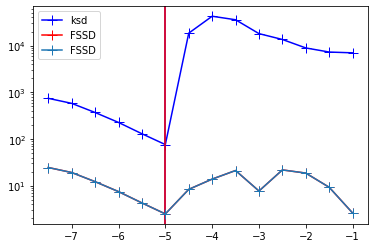

In [59]:
J = 10
key = random.PRNGKey(1)
V = random.normal(key, shape=(J, dim)) 

from tuning.mamba import timed_sampler

batch_size = int(0.1*X_train.shape[0])
build_kernel = lambda dt: build_sgld_kernel(dt, loglikelihood, logprior, data, batch_size)

timed_sampler_factory = timed_sampler(build_kernel)


ksd_list = []
FSSD_list = []

for logdt in logdt_range:
    print(f"logdt={logdt}")
    dt = 10**(logdt)
    run_timed_sampler = timed_sampler_factory(dt)
    samples, grads = run_timed_sampler(key, 1, theta_true)

    samples = jnp.array(samples)
    grads = jnp.array(grads)
    print(f"Num samples: {samples.shape}")
    
    ksd_list.append(imq_KSD(samples, grads))
    FSSD_list.append(FSSD(samples, grads, V))
    

plt.plot(logdt_range, ksd_list, marker="+", markersize=10, label="ksd", c='b')
plt.plot(logdt_range, FSSD_list, marker="+", markersize=10, label="FSSD", c='r')
plt.legend()
plt.yscale("log")


plt.axvline(logdt_range[np.argmin(ksd_list)], c='b')
plt.axvline(logdt_range[np.argmin(FSSD_list)], c='r')

plt.plot(logdt_range, FSSD_list, marker="+", markersize=10, label="FSSD")
plt.legend()



In [54]:
J = 10
key = random.PRNGKey(1)
V = random.normal(key, shape=(J, dim)) 

In [55]:
from tuning.mamba import timed_sampler

batch_size = int(0.01*X_train.shape[0])
build_kernel = lambda dt: build_sgld_kernel(dt, loglikelihood, logprior, data, batch_size)

timed_sampler_factory = timed_sampler(build_kernel)


In [56]:
ksd_list = []
FSSD_list = []

for logdt in logdt_range:
    print(f"logdt={logdt}")
    dt = 10**(logdt)
    run_timed_sampler = timed_sampler_factory(dt)
    samples, grads = run_timed_sampler(key, 1, theta_true)

    samples = jnp.array(samples)
    grads = jnp.array(grads)
    print(f"Num samples: {samples.shape}")
    
    ksd_list.append(imq_KSD(samples, grads))
    FSSD_list.append(FSSD(samples, grads, V))
    

logdt=-1.0
Num samples: (2142, 10)
logdt=-1.5
Num samples: (2176, 10)
logdt=-2.0
Num samples: (2203, 10)
logdt=-2.5
Num samples: (2178, 10)
logdt=-3.0
Num samples: (2161, 10)
logdt=-3.5
Num samples: (2175, 10)
logdt=-4.0
Num samples: (2253, 10)
logdt=-4.5
Num samples: (2158, 10)
logdt=-5.0
Num samples: (2168, 10)
logdt=-5.5
Num samples: (1886, 10)
logdt=-6.0
Num samples: (2005, 10)
logdt=-6.5
Num samples: (2253, 10)
logdt=-7.0
Num samples: (1423, 10)
logdt=-7.5
Num samples: (1624, 10)


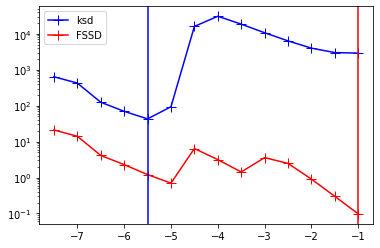

In [57]:
plt.plot(logdt_range, ksd_list, marker="+", markersize=10, label="ksd", c='b')
plt.plot(logdt_range, FSSD_list, marker="+", markersize=10, label="FSSD", c='r')
plt.legend()
plt.yscale("log")


plt.axvline(logdt_range[np.argmin(ksd_list)], c='b')
plt.axvline(logdt_range[np.argmin(FSSD_list)], c='r')

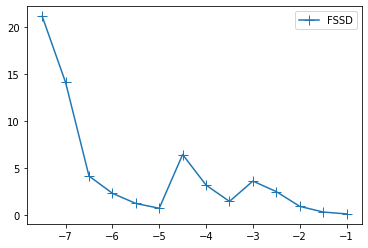

In [58]:
plt.plot(logdt_range, FSSD_list, marker="+", markersize=10, label="FSSD")
plt.legend()

## sgld-cv

In [31]:
J = 10
key = random.PRNGKey(1)
V = random.normal(key, shape=(J, dim))

In [41]:
from tuning.mamba import timed_sampler

batch_size = int(0.1*X_train.shape[0])
build_kernel = lambda dt: build_sgldCV_kernel(dt, loglikelihood, logprior, data, batch_size, centering_value)

timed_sampler_factory = timed_sampler(build_kernel)


In [42]:
ksd_list = []
FSSD_list = []

for logdt in logdt_range:
    print(f"logdt={logdt}")
    dt = 10**(logdt)
    run_timed_sampler = timed_sampler_factory(dt)
    samples, grads = run_timed_sampler(key, 1, theta_true)

    samples = jnp.array(samples)
    grads = jnp.array(grads)
    print(f"Num samples: {samples.shape}")
    
    ksd_list.append(imq_KSD(samples, grads))
    FSSD_list.append(FSSD(samples, grads, V))
    

logdt=-1.0
Num samples: (272, 10)
logdt=-1.5
Num samples: (279, 10)
logdt=-2.0
Num samples: (284, 10)
logdt=-2.5
Num samples: (289, 10)
logdt=-3.0
Num samples: (295, 10)
logdt=-3.5
Num samples: (298, 10)
logdt=-4.0
Num samples: (294, 10)
logdt=-4.5
Num samples: (284, 10)
logdt=-5.0
Num samples: (277, 10)
logdt=-5.5
Num samples: (284, 10)
logdt=-6.0
Num samples: (296, 10)
logdt=-6.5
Num samples: (291, 10)
logdt=-7.0
Num samples: (292, 10)
logdt=-7.5
Num samples: (294, 10)


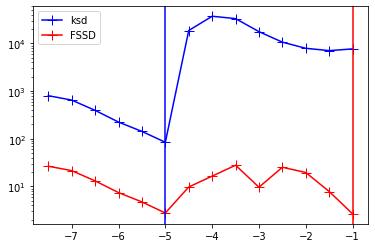

In [43]:
plt.plot(logdt_range, ksd_list, marker="+", markersize=10, label="ksd", c='b')
plt.plot(logdt_range, FSSD_list, marker="+", markersize=10, label="FSSD", c='r')
plt.legend()
plt.yscale("log")


plt.axvline(logdt_range[np.argmin(ksd_list)], c='b')
plt.axvline(logdt_range[np.argmin(FSSD_list)], c='r')

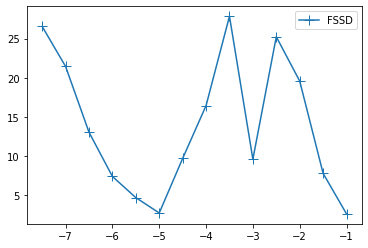

In [44]:
plt.plot(logdt_range, FSSD_list, marker="+", markersize=10, label="FSSD")
plt.legend()


Running gridsearch for dt
Number of grid points: 14
{'dt': 0.1}



{'dt': 0.031622775}



{'dt': 0.01}



{'dt': 0.0031622776}



{'dt': 0.001}



{'dt': 0.00031622776}



{'dt': 1e-04}



{'dt': 3.1622778e-05}



{'dt': 1e-05}



{'dt': 3.1622776e-06}



{'dt': 1e-06}



{'dt': 3.1622776e-07}



{'dt': 1e-07}



{'dt': 3.1622776e-08}



Running time for gridsearch: 337 sec

Optimal hyperparameter: {'dt': 1e-06}


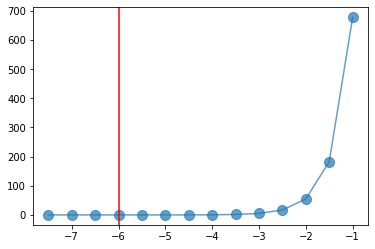

In [4]:
build_kernel = lambda dt: build_sgld_kernel(dt, loglikelihood, logprior, data, batch_size)

grid_params = {'log_dt': logdt_range}
list_hyperparams, ll_list = run_gridsearch(key, build_kernel, error_fn, Niters, params_IC, grid_params)

log_dt_grid = [np.log10(elem['dt']) for elem in list_hyperparams]
plt.plot(log_dt_grid, ll_list, marker="o", markersize=10, alpha=0.7)
plt.axvline(log_dt_grid[np.nanargmin(ll_list)], c='r')

print(f"\nOptimal hyperparameter: {list_hyperparams[np.nanargmin(ll_list)]}")

Running gridsearch for dt
Number of grid points: 14
{'dt': 0.1}



{'dt': 0.031622775}



{'dt': 0.01}



{'dt': 0.0031622776}



{'dt': 0.001}



{'dt': 0.00031622776}



{'dt': 1e-04}



{'dt': 3.1622778e-05}



{'dt': 1e-05}



{'dt': 3.1622776e-06}



{'dt': 1e-06}



{'dt': 3.1622776e-07}



{'dt': 1e-07}



{'dt': 3.1622776e-08}



Running time for gridsearch: 348 sec

Optimal hyperparameter: {'dt': 1e-05}


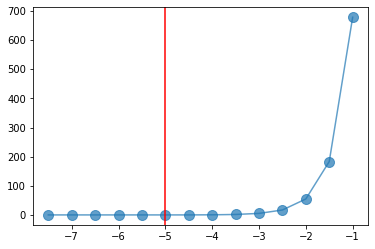

In [5]:
build_kernel = lambda dt: build_sgldCV_kernel(dt, loglikelihood, logprior, data, batch_size, centering_value)

grid_params = {'log_dt': logdt_range}
list_hyperparams, ll_list = run_gridsearch(key, build_kernel, error_fn, Niters, params_IC, grid_params)

log_dt_grid = [np.log10(elem['dt']) for elem in list_hyperparams]
plt.plot(log_dt_grid, ll_list, marker="o", markersize=10, alpha=0.7)
plt.axvline(log_dt_grid[np.nanargmin(ll_list)], c='r')

print(f"\nOptimal hyperparameter: {list_hyperparams[np.nanargmin(ll_list)]}")

In [6]:
build_kernel = lambda dt, L: build_sghmc_kernel(dt, L, loglikelihood, logprior, data, batch_size)

grid_params = {'log_dt': logdt_range, "L": [5,10]}
list_hyperparams, ll_list = run_gridsearch(key, build_kernel, error_fn, Niters, params_IC, grid_params)

print(f"\nOptimal hyperparameter: {list_hyperparams[np.nanargmin(ll_list)]}")

Running gridsearch for L, dt
Number of grid points: 28
{'L': 5, 'dt': 0.1}



{'L': 5, 'dt': 0.031622775}



{'L': 5, 'dt': 0.01}



{'L': 5, 'dt': 0.0031622776}



{'L': 5, 'dt': 0.001}



{'L': 5, 'dt': 0.00031622776}



{'L': 5, 'dt': 1e-04}



{'L': 5, 'dt': 3.1622778e-05}



{'L': 5, 'dt': 1e-05}



{'L': 5, 'dt': 3.1622776e-06}



{'L': 5, 'dt': 1e-06}



{'L': 5, 'dt': 3.1622776e-07}



{'L': 5, 'dt': 1e-07}



{'L': 5, 'dt': 3.1622776e-08}



{'L': 10, 'dt': 0.1}



{'L': 10, 'dt': 0.031622775}



{'L': 10, 'dt': 0.01}



{'L': 10, 'dt': 0.0031622776}



{'L': 10, 'dt': 0.001}



{'L': 10, 'dt': 0.00031622776}



{'L': 10, 'dt': 1e-04}



{'L': 10, 'dt': 3.1622778e-05}



{'L': 10, 'dt': 1e-05}



{'L': 10, 'dt': 3.1622776e-06}



{'L': 10, 'dt': 1e-06}



{'L': 10, 'dt': 3.1622776e-07}



{'L': 10, 'dt': 1e-07}



{'L': 10, 'dt': 3.1622776e-08}



Running time for gridsearch: 1050 sec

Optimal hyperparameter: {'L': 10, 'dt': 1e-07}


In [7]:
build_kernel = lambda dt, L: build_sghmcCV_kernel(dt, L, loglikelihood, logprior, data, batch_size, centering_value)

grid_params = {'log_dt': logdt_range, "L": [5,10]}
list_hyperparams, ll_list = run_gridsearch(key, build_kernel, error_fn, Niters, params_IC, grid_params)

print(f"\nOptimal hyperparameter: {list_hyperparams[np.nanargmin(ll_list)]}")

Running gridsearch for L, dt
Number of grid points: 28
{'L': 5, 'dt': 0.1}



{'L': 5, 'dt': 0.031622775}



{'L': 5, 'dt': 0.01}



{'L': 5, 'dt': 0.0031622776}



{'L': 5, 'dt': 0.001}



{'L': 5, 'dt': 0.00031622776}



{'L': 5, 'dt': 1e-04}



{'L': 5, 'dt': 3.1622778e-05}



{'L': 5, 'dt': 1e-05}



{'L': 5, 'dt': 3.1622776e-06}



{'L': 5, 'dt': 1e-06}



{'L': 5, 'dt': 3.1622776e-07}



{'L': 5, 'dt': 1e-07}



{'L': 5, 'dt': 3.1622776e-08}



{'L': 10, 'dt': 0.1}



{'L': 10, 'dt': 0.031622775}



{'L': 10, 'dt': 0.01}



{'L': 10, 'dt': 0.0031622776}



{'L': 10, 'dt': 0.001}



{'L': 10, 'dt': 0.00031622776}



{'L': 10, 'dt': 1e-04}



{'L': 10, 'dt': 3.1622778e-05}



{'L': 10, 'dt': 1e-05}



{'L': 10, 'dt': 3.1622776e-06}



{'L': 10, 'dt': 1e-06}



{'L': 10, 'dt': 3.1622776e-07}



{'L': 10, 'dt': 1e-07}



{'L': 10, 'dt': 3.1622776e-08}



Running time for gridsearch: 1186 sec

Optimal hyperparameter: {'L': 10, 'dt': 3.1622776e-07}


Running gridsearch for dt
Number of grid points: 14
{'dt': 0.1}



{'dt': 0.031622775}



{'dt': 0.01}



{'dt': 0.0031622776}



{'dt': 0.001}



{'dt': 0.00031622776}



{'dt': 1e-04}



{'dt': 3.1622778e-05}



{'dt': 1e-05}



{'dt': 3.1622776e-06}



{'dt': 1e-06}



{'dt': 3.1622776e-07}



{'dt': 1e-07}



{'dt': 3.1622776e-08}



Running time for gridsearch: 289 sec

Optimal hyperparameter: {'dt': 3.1622776e-08}


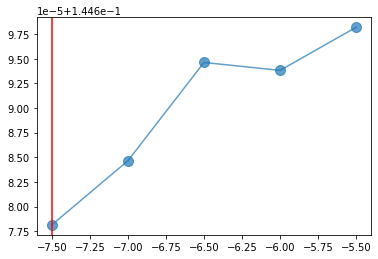

In [8]:
build_kernel = lambda dt: build_sgnht_kernel(dt, loglikelihood, logprior, data, batch_size)

grid_params = {'log_dt': logdt_range}
list_hyperparams, ll_list = run_gridsearch(key, build_kernel, error_fn, Niters, params_IC, grid_params)

log_dt_grid = [np.log10(elem['dt']) for elem in list_hyperparams]
plt.plot(log_dt_grid, ll_list, marker="o", markersize=10, alpha=0.7)
plt.axvline(log_dt_grid[np.nanargmin(ll_list)], c='r')

print(f"\nOptimal hyperparameter: {list_hyperparams[np.nanargmin(ll_list)]}")

Running gridsearch for dt
Number of grid points: 14
{'dt': 0.1}



{'dt': 0.031622775}



{'dt': 0.01}



{'dt': 0.0031622776}



{'dt': 0.001}



{'dt': 0.00031622776}



{'dt': 1e-04}



{'dt': 3.1622778e-05}



{'dt': 1e-05}



{'dt': 3.1622776e-06}



{'dt': 1e-06}



{'dt': 3.1622776e-07}



{'dt': 1e-07}



{'dt': 3.1622776e-08}



Running time for gridsearch: 408 sec

Optimal hyperparameter: {'dt': 3.1622778e-05}


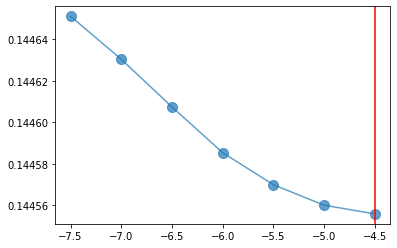

In [9]:
build_kernel = lambda dt: build_sgnhtCV_kernel(dt, loglikelihood, logprior, data, batch_size, centering_value)

grid_params = {'log_dt': logdt_range}
list_hyperparams, ll_list = run_gridsearch(key, build_kernel, error_fn, Niters, params_IC, grid_params)

log_dt_grid = [np.log10(elem['dt']) for elem in list_hyperparams]
plt.plot(log_dt_grid, ll_list, marker="o", markersize=10, alpha=0.7)
plt.axvline(log_dt_grid[np.nanargmin(ll_list)], c='r')

print(f"\nOptimal hyperparameter: {list_hyperparams[np.nanargmin(ll_list)]}")